In [2]:
import pandas as pd
import synapseclient
import synapseutils
import os
import configparser
from collections import OrderedDict

config_path = os.path.join(os.environ['HOME'], '.synapseConfig')
cfg = configparser.ConfigParser()
cfg.read(config_path)
syn_usr = cfg.get("authentication", "username")
syn_pwd = cfg.get("authentication", "password")
syn = synapseclient.login(email=syn_usr, password=syn_pwd, rememberMe=True)


sub2_synapse_id = 'syn10139539'
# if 'files' not in locals():
files = synapseutils.syncFromSynapse(syn, sub2_synapse_id)

data_dict = OrderedDict()
for fl in files:
    data_dict[fl.name] = pd.read_csv(fl.path, sep='\t')

Welcome, Joy Rimchala!



# Read the data and summarize

In [3]:
import pandas as pd
import synapseclient
import synapseutils
import os
import configparser
from collections import OrderedDict

sub2_dir = '../data/sub2/'
bre_rnaseq = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_rna_seq_sort_common_gene_15115.txt'), sep='\t')
bre_cna = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_CNA_median_sort_common_gene_16884.txt'), sep='\t')
bre_proteome = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_proteome_filtered.txt'), sep='\t')
print("Breast Cancer Data Summary ")
print("="*70)
print("RNASeq   : No.Samples : {}, No.Genes: {}".format(len(bre_rnaseq.columns)-1, len(bre_rnaseq)))
print("CNA      : No.Samples : {}, No.Genes: {}".format(len(bre_cna.columns)-1, len(bre_cna)))
print("Proteome : No.Samples : {}, No.Genes: {}".format(len(bre_proteome.columns)-1, len(bre_proteome)))
print("\n")
ova_rnaseq = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_rna_seq_sort_common_gene_15632.txt'), sep='\t')
ova_cna = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_CNA_sort_common_gene_11859.txt'), sep='\t')
ova_proteome = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_proteome_filtered.txt'), sep='\t')

print("Overian Cancer Data Summary ")
print("="*70)
print("RNASeq   : No.Samples : {}, No.Gene: {}".format(len(ova_rnaseq.columns)-1, len(ova_rnaseq)))
print("CNA      : No.Samples : {}, No.Gene: {}".format(len(ova_cna.columns)-1, len(ova_cna)))
print("Proteome : No.Samples : {}, No.Gene: {}".format(len(ova_proteome.columns)-1, len(ova_proteome)))


Breast Cancer Data Summary 
RNASeq   : No.Samples : 77, No.Genes: 15115
CNA      : No.Samples : 77, No.Genes: 16884
Proteome : No.Samples : 105, No.Genes: 10597


Overian Cancer Data Summary 
RNASeq   : No.Samples : 294, No.Gene: 15632
CNA      : No.Samples : 559, No.Gene: 11859
Proteome : No.Samples : 174, No.Gene: 7163


## Filter for PAM50

In [ ]:
# %%sh
# wget https://genome.unc.edu/pubsup/breastGEO/pam50_centroids.txt ../data/sub2/

In [ ]:
# Filter criteria 
# 1. PAM 50 gene list
# 2. sample with QC status == pass
# 3. Protein shows up in >= 25% of the samples

In [81]:
import pandas as pd
sample_cols = [c for c in bre_proteome.columns if c.startswith('TCGA')]

def filter_PAM50(df, PAM50, gene_col='Gene_ID'):
    return df[df[gene_col].apply(lambda x: x in PAM50)]

PAM50_df = pd.read_csv('../data/sub2/pam50_centroids.txt', sep='\t')
PAM50_df = PAM50_df.rename(columns={'Unnamed: 0': 'Gene_ID'})
PAM50 = set(PAM50_df['Gene_ID'])

PAM50_bre_rnaseq = filter_PAM50(bre_rnaseq, PAM50)
PAM50_bre_cna = filter_PAM50(bre_cna, PAM50)
PAM50_bre_proteome = filter_PAM50(bre_proteome, PAM50)

print("No.Genes before PAM50 filter: {}".format(str(len(bre_proteome['Gene_ID'].unique()))))
print("No.Genes after PAM50 filter: {}".format(str(len(PAM50_bre_proteome['Gene_ID'].unique()))))

No.Genes before PAM50 filter: 10597
No.Genes after PAM50 filter: 43


# Filter for Samples with QC status='pass'

In [91]:
suppl_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')

suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

QCfitered_samples = suppl_data[suppl_data['QC Status']=='pass']
print("No. Samples before QC filter: {}".format(str(len(suppl_data['TCGA ID'].unique()))))
print("No. Samples after QC filter: {}".format(str(len(QCfitered_samples['TCGA ID'].unique()))))

No. Samples before QC filter: 105
No. Samples after QC filter: 77


array(['TCGA-A2-A0CM', 'TCGA-A2-A0D2', 'TCGA-A2-A0EQ', 'TCGA-A2-A0EV',
       'TCGA-A2-A0EX', 'TCGA-A2-A0EY', 'TCGA-A2-A0SW', 'TCGA-A2-A0SX',
       'TCGA-A2-A0T3', 'TCGA-A2-A0T6', 'TCGA-A2-A0YC', 'TCGA-A2-A0YD',
       'TCGA-A2-A0YF', 'TCGA-A2-A0YG', 'TCGA-A2-A0YM', 'TCGA-A7-A0CE',
       'TCGA-A7-A0CJ', 'TCGA-A7-A13F', 'TCGA-A8-A06N', 'TCGA-A8-A06Z',
       'TCGA-A8-A076', 'TCGA-A8-A079', 'TCGA-A8-A08Z', 'TCGA-A8-A09G',
       'TCGA-AN-A04A', 'TCGA-AN-A0AJ', 'TCGA-AN-A0AL', 'TCGA-AN-A0AM',
       'TCGA-AN-A0FK', 'TCGA-AN-A0FL', 'TCGA-AO-A03O', 'TCGA-AO-A0J6',
       'TCGA-AO-A0J9', 'TCGA-AO-A0JC', 'TCGA-AO-A0JE', 'TCGA-AO-A0JJ',
       'TCGA-AO-A0JL', 'TCGA-AO-A0JM', 'TCGA-AO-A126', 'TCGA-AO-A12B',
       'TCGA-AO-A12D', 'TCGA-AO-A12E', 'TCGA-AO-A12F', 'TCGA-AR-A0TR',
       'TCGA-AR-A0TT', 'TCGA-AR-A0TV', 'TCGA-AR-A0TX', 'TCGA-AR-A0U4',
       'TCGA-AR-A1AP', 'TCGA-AR-A1AS', 'TCGA-AR-A1AV', 'TCGA-AR-A1AW',
       'TCGA-BH-A0AV', 'TCGA-BH-A0BV', 'TCGA-BH-A0C1', 'TCGA-BH-A0C7',
      

# Filter for gene showing up in more 25% sample

In [138]:
QCfiltered_bre_proteome = PAM50_bre_proteome[['Gene_ID'] + list(QCfitered_samples['TCGA ID'].values)]
total_samples = len(QCfitered_samples['TCGA ID'].unique())
appearance_count_by_gene = (
    pd.DataFrame(pd.notnull(QCfiltered_bre_proteome.set_index('Gene_ID')).astype(float).T.sum(), columns=['appearance'])
).reset_index()
QCfiltered_bre_proteome = QCfiltered_bre_proteome.merge(appearance_count_by_gene, on='Gene_ID', how='left')
QCfiltered_bre_proteome['percent_appearance'] = QCfiltered_bre_proteome['appearance']/total_samples
appearance_filtered = QCfiltered_bre_proteome[QCfiltered_bre_proteome['percent_appearance'] > 0.25]

print("No. Genes before appearance filter: {}".format( len(QCfiltered_bre_proteome['Gene_ID'].unique()) ) )
print("No. Genes before appearance filter: {}".format( len(appearance_filtered['Gene_ID'].unique()) ) )

No. Genes before appearance filter: 43
No. Genes before appearance filter: 39


In [157]:
genes_to_clusters = appearance_filtered['Gene_ID'].values
sample_to_clusters = QCfitered_samples['TCGA ID'].values
cna_to_cluster = (
    bre_cna
        # filter genes (rows)
        [bre_cna['Gene_ID'].apply(lambda x: x in genes_to_clusters)]
        # filter samples (columns)
        [['Gene_ID'] + list(sample_to_clusters)]
 )
                  
rnaseq_to_cluster = (
    bre_rnaseq
    [bre_rnaseq['Gene_ID'].apply(lambda x: x in genes_to_clusters)]
    [['Gene_ID'] + list(sample_to_clusters)]
)

proteome_to_cluster = appearance_filtered

In [5]:
def invert_and_append_columns(df, index_col=None, prefix=None, suffix=None):
    df = df.set_index(index_col).T if index_col is not None else df.T
    prefix = '' if (prefix is None) or len(prefix) == 0 else prefix + '_'
    suffix = '' if (suffix is None) or len(suffix) == 0 else '_' + suffix
    
    df.columns = prefix + df.columns + suffix
    return df

PAM50_rnaseq = invert_and_append_columns(PAM50_bre_rnaseq, index_col="Gene_ID", suffix='rnaseq')
PAM50_cna = invert_and_append_columns(PAM50_bre_cna, index_col="Gene_ID", suffix='cna')
PAM50_proteome = invert_and_append_columns(PAM50_bre_proteome, index_col="Gene_ID", suffix='proteome')
suppl_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')

suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

all_PAM50 = (
    PAM50_proteome
        .merge(PAM50_rnaseq, left_index=True, right_index=True, how='left')
        .merge(PAM50_cna, left_index=True, right_index=True, how='left')
        .merge(suppl_data[suppl_cols], left_index=True, right_on='TCGA ID')
)

final_cols = ['TCGA ID'] + list(
    PAM50_proteome.columns
    .append(PAM50_rnaseq.columns)
    .append(PAM50_cna.columns)
) + list(filter(lambda x: x != 'TCGA ID', suppl_cols))

all_PAM50[final_cols]
print(len(all_PAM50.columns), len(all_PAM50))

150 105


## Hierarchical Clustering

In [7]:
# Further scoping down the analysis
transposed_rnaseq = PAM50_bre_rnaseq.set_index('Gene_ID').T
transposed_rnaseq.columns = 'rna-' + transposed_rnaseq.columns
transposed_cna = PAM50_bre_cna.set_index('Gene_ID').T
transposed_cna.columns = 'cna-' + transposed_cna.columns
transposed_proteome = PAM50_bre_proteome.set_index('Gene_ID').T
transposed_proteome.columns = 'proteome-' + transposed_proteome.columns

breast_common_samples = (
    transposed_rnaseq
        .merge(transposed_cna, left_index=True, right_index=True)
        .merge(transposed_proteome, left_index=True, right_index=True)
).index

Populating the interactive namespace from numpy and matplotlib


/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


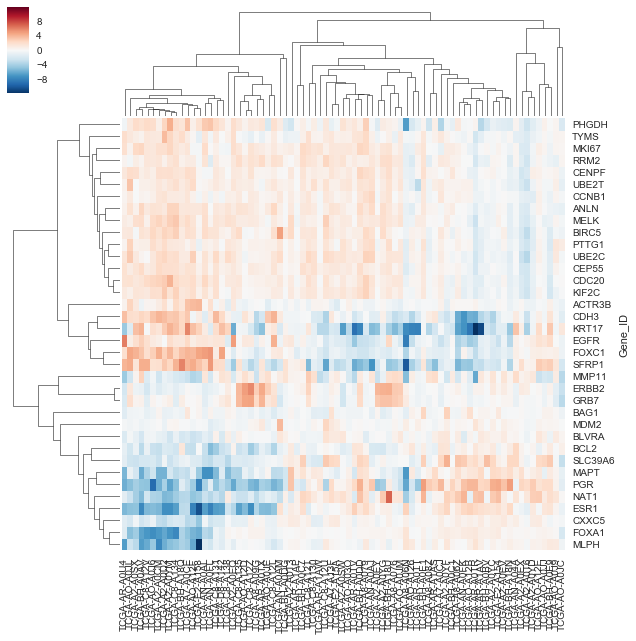

In [159]:
% pylab inline
import pandas as pd
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

gene_id = PAM50_bre_rnaseq["Gene_ID"]
lut = dict(zip(gene_id.unique(), "rbg"))
row_colors = gene_id.map(lut)
clust_rnaseq = sns.clustermap(rnaseq_to_cluster.set_index("Gene_ID").dropna(), metric="correlation")
plt.setp(clust_rnaseq.ax_heatmap.get_yticklabels(), rotation=0)
rnaseq_sample_clust, rnaseq_gene_clust = clust_rnaseq.dendrogram_col, clust_rnaseq.dendrogram_row

/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


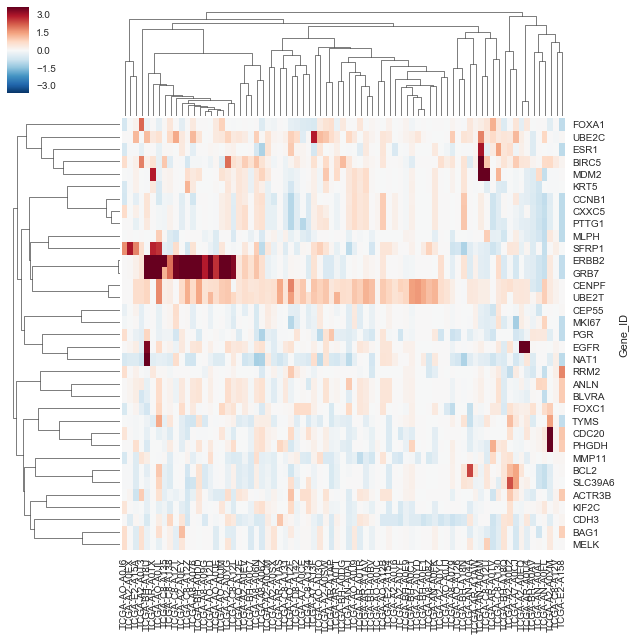

In [160]:
clust_cna = sns.clustermap(cna_to_cluster.set_index("Gene_ID").dropna(), metric="correlation")
plt.setp(clust_cna.ax_heatmap.get_yticklabels(), rotation=0)
cna_sample_clust, cna_gene_clust = clust_cna.dendrogram_col, clust_cna.dendrogram_row

/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


ValueError: Linkage 'Z' contains negative indices.

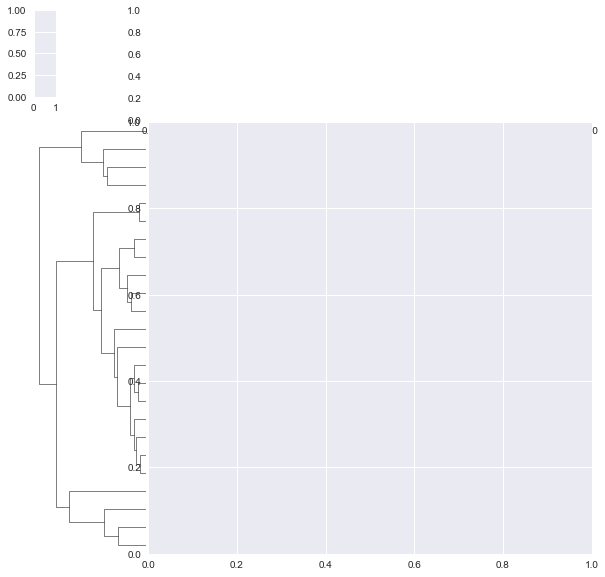

In [161]:
clust_proteome = sns.clustermap(proteome_to_cluster.set_index("Gene_ID").dropna(), metric="correlation")
plt.setp(clust_proteome.ax_heatmap.get_yticklabels(), rotation=0)
proteome_sample_clust, proteome_gene_clust = clust_proteome.dendrogram_col, clust_proteome.dendrogram_row

In [41]:
bre_rnaseq_35 = PAM50_bre_rnaseq[['Gene_ID'] + list(breast_common_samples)]
bre_cna_35 = PAM50_bre_cna[['Gene_ID'] + list(breast_common_samples)]
bre_proteome_35 = PAM50_bre_proteome[['Gene_ID'] + list(breast_common_samples)]

In [11]:
suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

In [40]:
paper_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')
paper_data[['Sample ID', 'QC Status']].groupby('QC Status').agg('count')

,Sample ID
QC Status,
fail,28
pass,77


In [57]:
merged = all_PAM50.merge(paper_data[suppl_cols], on='TCGA ID', how='outer')
merged

,ACTR3B_proteome,ANLN_proteome,BAG1_proteome,BCL2_proteome,BIRC5_proteome,BLVRA_proteome,CCNB1_proteome,CCNE1_proteome,CDC20_proteome,CDH3_proteome,...,Phosphoproteome Cluster (see Fig. 3b)_y,Phosphoproteome-pathways cluster (see Fig. 3d)_y,GATA3 Mutation_y,PIK3CA Mutation_y,TP53 Mutation_y,PIK3CA missense mutation in helical domain all tumors_y,PIK3CA missense mutation in kinase domain all tumors_y,TP53 Nonsense/Frameshift all tumors_y,TP53 Missense mutation all tumors_y,TP53 missense mutations in DNA binding domain all tumors_y
0,-0.215527,0.732422,-0.041051,-1.075505,1.223122,-0.607872,0.715536,0.771578,0.886451,0.704984,...,1.0,4.0,NaN,NaN,Frame_Shift_Del|Somatic|p.E204fs,0.0,0.0,1.0,NaN,NaN
1,0.067831,-0.505732,-0.728855,0.840877,2.687368,0.053454,0.575770,1.566049,-0.294646,2.329904,...,NaN,NaN,NaN,NaN,Nonsense_Mutation|Somatic|p.R196*,0.0,0.0,1.0,NaN,NaN
2,1.287414,-1.605155,0.687760,0.524293,1.717638,-0.192015,-1.053769,-0.693349,-1.038675,-0.150714,...,NaN,NaN,NaN,Missense_Mutation|Somatic|p.E542K,Nonsense_Mutation|Somatic|p.Q331*,1.0,NaN,1.0,NaN,NaN
3,0.669311,0.736708,-0.693039,-1.166615,1.374994,-0.576575,0.823457,NaN,0.834058,0.932774,...,1.0,4.0,NaN,NaN,Frame_Shift_Del|Somatic|p.P318fs,0.0,0.0,1.0,NaN,NaN
4,-0.062352,-0.113729,-0.142621,0.606521,0.600182,-0.574350,-0.074480,NaN,-0.307294,-0.900292,...,1.0,4.0,NaN,Missense_Mutation|Somatic|p.H1047R,In_Frame_Del|Somatic|p.IY162in_frame_delN,NaN,1.0,NaN,NaN,NaN
5,0.300089,-1.234507,-0.083005,0.913689,-0.161032,0.296456,-0.972382,NaN,-1.508631,0.001208,...,3.0,2.0,NaN,In_Frame_Ins|Somatic|p.E469in_frame_insDK,NaN,NaN,NaN,0.0,0.0,0.0
6,0.087244,-0.548382,-0.012298,0.033338,-1.069528,-0.180249,-0.810338,NaN,-1.020156,-0.145740,...,3.0,2.0,NaN,Missense_Mutation|Somatic|p.E545K,NaN,1.0,NaN,0.0,0.0,0.0
7,-0.137324,-0.216304,-0.002790,-1.616200,-0.369602,-0.248067,-0.511745,NaN,-0.051865,-0.091229,...,3.0,1.0,NaN,Missense_Mutation|Somatic|p.G118D,Missense_Mutation|Somatic|p.Y234C,NaN,NaN,NaN,1.0,1.0
8,-0.437167,0.097269,0.095371,-0.068135,0.344148,0.423686,0.313737,0.411451,-0.162005,-0.679790,...,3.0,1.0,NaN,NaN,Missense_Mutation|Somatic|p.R273C,0.0,0.0,NaN,1.0,1.0
9,-0.350402,1.225958,-0.351227,-0.391147,NaN,-0.391584,NaN,NaN,0.216261,-0.560759,...,3.0,1.0,NaN,NaN,Missense_Mutation|Somatic|p.G199V,0.0,0.0,NaN,1.0,1.0


In [33]:
proteome_cols = [c for c in merged.columns if c.endswith('proteome')]
non_proteome_cols = [c for c in merged.columns if not c.endswith('proteome')]
y = merged[proteome_cols].as_matrix()
X = merged[non_proteome_cols].as_matrix()

In [61]:
bre_proteome_35

,Gene_ID,TCGA-A2-A0CM,TCGA-A2-A0D2,TCGA-A2-A0EQ,TCGA-A2-A0EV,TCGA-A2-A0EX,TCGA-A2-A0EY,TCGA-A2-A0SW,TCGA-A2-A0SX,TCGA-A2-A0T3,...,TCGA-C8-A12Z,TCGA-C8-A130,TCGA-C8-A131,TCGA-C8-A134,TCGA-C8-A135,TCGA-C8-A138,TCGA-D8-A142,TCGA-E2-A154,TCGA-E2-A158,TCGA-E2-A15A
146,ACTR3B,-0.215527,0.669311,-0.062352,0.300089,0.087244,-0.137324,-0.437167,-0.350402,-0.000604,...,0.254438,0.052926,0.044845,0.364245,-0.239793,-0.173734,-0.446038,0.430075,0.707461,-0.449117
442,ANLN,0.732422,0.736708,-0.113729,-1.234507,-0.548382,-0.216304,0.097269,1.225958,0.324544,...,-0.752338,0.173882,0.453418,0.826307,-0.636951,0.417706,-0.459147,-0.837927,0.117872,0.304871
854,BAG1,-0.041051,-0.693039,-0.142621,-0.083005,-0.012298,-0.002790,0.095371,-0.351227,0.218035,...,0.308540,-0.533466,-0.381807,-0.579374,-0.281486,0.039310,-0.344900,0.989667,0.331488,-0.049033
906,BCL2,-1.075505,-1.166615,0.606521,0.913689,0.033338,-1.616200,-0.068135,-0.391147,-0.239632,...,-0.597293,-0.819043,-1.198451,-1.816095,-1.062394,-1.239735,-0.182518,-0.908413,0.020079,-0.605506
945,BIRC5,1.223122,1.374994,0.600182,-0.161032,-1.069528,-0.369602,0.344148,NaN,0.638163,...,0.811443,0.290692,0.149708,0.912391,NaN,-1.274020,0.000592,-0.858495,0.102409,-0.013641
956,BLVRA,-0.607872,-0.576575,-0.574350,0.296456,-0.180249,-0.248067,0.423686,-0.391584,-0.580939,...,0.382099,-0.421073,-0.067269,-0.620315,0.174900,-0.051757,-0.435551,0.544512,-1.114480,0.285331
1455,CCNB1,0.715536,0.823457,-0.074480,-0.972382,-0.810338,-0.511745,0.313737,NaN,0.330145,...,0.072670,0.130139,0.411777,0.541688,0.347826,-0.032013,-0.376311,-1.192646,-0.333934,-0.042904
1460,CCNE1,0.771578,NaN,NaN,NaN,NaN,NaN,0.411451,NaN,NaN,...,NaN,0.419854,-0.498727,NaN,NaN,0.232005,NaN,-1.573464,NaN,NaN
1545,CDC20,0.886451,0.834058,-0.307294,-1.508631,-1.020156,-0.051865,-0.162005,0.216261,0.286150,...,-1.721557,0.070327,0.448939,0.637184,-0.537837,-0.564031,-0.327713,-1.389527,-0.284058,-0.115151
1581,CDH3,0.704984,0.932774,-0.900292,0.001208,-0.145740,-0.091229,-0.679790,-0.560759,-0.038394,...,0.164977,-0.183021,0.576200,1.398890,-0.239800,-0.132401,1.094728,-0.212804,0.023863,-0.175066


In [60]:
PAM50_proteome

,ACTR3B_proteome,ANLN_proteome,BAG1_proteome,BCL2_proteome,BIRC5_proteome,BLVRA_proteome,CCNB1_proteome,CCNE1_proteome,CDC20_proteome,CDH3_proteome,...,NAT1_proteome,PGR_proteome,PHGDH_proteome,PTTG1_proteome,RRM2_proteome,SFRP1_proteome,SLC39A6_proteome,TYMS_proteome,UBE2C_proteome,UBE2T_proteome
TCGA-A2-A0CM,-0.215527,0.732422,-0.041051,-1.075505,1.223122,-0.607872,0.715536,0.771578,0.886451,0.704984,...,-1.439999,-1.622406,-0.314279,0.276105,0.248628,0.184656,-0.413699,-0.148644,0.779568,0.883699
TCGA-A2-A0D0,0.067831,-0.505732,-0.728855,0.840877,2.687368,0.053454,0.575770,1.566049,-0.294646,2.329904,...,-0.385955,-1.710569,0.727022,NaN,0.470975,1.324270,-1.639602,1.617110,1.325203,-0.126689
TCGA-A2-A0D1,1.287414,-1.605155,0.687760,0.524293,1.717638,-0.192015,-1.053769,-0.693349,-1.038675,-0.150714,...,-0.181670,-1.038621,2.019501,-0.003581,0.359590,-0.174814,0.403071,-1.308405,0.404059,0.178238
TCGA-A2-A0D2,0.669311,0.736708,-0.693039,-1.166615,1.374994,-0.576575,0.823457,NaN,0.834058,0.932774,...,-2.097064,-1.710917,0.704783,-0.648861,-0.056400,2.088758,-0.165421,1.787511,0.618501,0.804999
TCGA-A2-A0EQ,-0.062352,-0.113729,-0.142621,0.606521,0.600182,-0.574350,-0.074480,NaN,-0.307294,-0.900292,...,-0.864655,-1.622348,0.442304,0.134871,-0.006043,-1.196002,0.101670,0.383516,0.242817,0.197380
TCGA-A2-A0EV,0.300089,-1.234507,-0.083005,0.913689,-0.161032,0.296456,-0.972382,NaN,-1.508631,0.001208,...,0.239427,-0.199352,-0.333376,NaN,-0.360368,0.527323,NaN,-0.778211,-0.556629,-0.149568
TCGA-A2-A0EX,0.087244,-0.548382,-0.012298,0.033338,-1.069528,-0.180249,-0.810338,NaN,-1.020156,-0.145740,...,-0.708272,0.321705,-0.692981,NaN,-0.700005,0.357509,-0.128557,-0.584094,-0.946262,-0.791227
TCGA-A2-A0EY,-0.137324,-0.216304,-0.002790,-1.616200,-0.369602,-0.248067,-0.511745,NaN,-0.051865,-0.091229,...,-1.320560,-1.915882,-0.552540,-0.148506,-0.415991,0.190072,NaN,-0.137811,-0.377671,-0.260343
TCGA-A2-A0SW,-0.437167,0.097269,0.095371,-0.068135,0.344148,0.423686,0.313737,0.411451,-0.162005,-0.679790,...,-0.674394,-0.581247,0.410633,NaN,-0.195112,-0.236613,-0.128280,0.166943,0.582599,0.310919
TCGA-A2-A0SX,-0.350402,1.225958,-0.351227,-0.391147,NaN,-0.391584,NaN,NaN,0.216261,-0.560759,...,-1.431730,-1.568061,0.464836,NaN,-0.855314,0.414126,-0.423177,0.321205,0.095045,-0.355785


In [56]:
paper_data[paper_data['QC Status'] == 'pass']

,Sample ID,TCGA ID,Biospecimen Barcode Side,UIUD,PAM50,ER Status,PR Status,HER2 Status,QC Status,Proteome Cluster (see Fig. 3b),...,iTRAQReporterIon,CommonControl,GATA3 Mutation,PIK3CA Mutation,TP53 Mutation,PIK3CA missense mutation in helical domain all tumors,PIK3CA missense mutation in kinase domain all tumors,TP53 Nonsense/Frameshift all tumors,TP53 Missense mutation all tumors,TP53 missense mutations in DNA binding domain all tumors
0,A2-A0CM,TCGA-A2-A0CM,TCGA-A2-A0CM-01A-11-A21V-30,330F7598-824C-4CD6-9303-A27FE74A6695,Basal,Negative,Negative,Negative,pass,1.0,...,116,YES,NaN,NaN,Frame_Shift_Del|Somatic|p.E204fs,0.0,0.0,1.0,NaN,NaN
1,A2-A0D2,TCGA-A2-A0D2,TCGA-A2-A0D2-01A-12-A21W-30,308CCD79-C164-4397-92BC-A1CD243C8E7D,Basal,Negative,Negative,Negative,pass,1.0,...,114,NO,NaN,NaN,Frame_Shift_Del|Somatic|p.P318fs,0.0,0.0,1.0,NaN,NaN
2,A2-A0EQ,TCGA-A2-A0EQ,TCGA-A2-A0EQ-01A-41-A21W-30,04217F65-2907-478B-B0C5-EB65370198DA,Her2,Negative,Negative,Positive,pass,1.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.H1047R,In_Frame_Del|Somatic|p.IY162in_frame_delN,NaN,1.0,NaN,NaN,NaN
3,A2-A0EV,TCGA-A2-A0EV,TCGA-A2-A0EV-01A-41-A21V-30,38F98E5F-7FA4-4C89-8D81-516CF865BEEB,LumA,Positive,Positive,Negative,pass,3.0,...,114,NO,NaN,In_Frame_Ins|Somatic|p.E469in_frame_insDK,NaN,NaN,NaN,0.0,0.0,0.0
4,A2-A0EX,TCGA-A2-A0EX,TCGA-A2-A0EX-01A-41-A21V-30,78271500-147B-40C5-B789-0CF0C7CDBCE2,LumA,Positive,Positive,Negative,pass,3.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.E545K,NaN,1.0,NaN,0.0,0.0,0.0
5,A2-A0EY,TCGA-A2-A0EY,TCGA-A2-A0EY-01A-41-A21V-30,87BBBD20-9816-4B22-917A-27CE73B1C0CA,LumB,Positive,Negative,Positive,pass,3.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.G118D,Missense_Mutation|Somatic|p.Y234C,NaN,NaN,NaN,1.0,1.0
6,A2-A0SW,TCGA-A2-A0SW,TCGA-A2-A0SW-01A-41-A21V-30,72EBF4A2-D75B-4344-B128-979DEC315C24,LumB,Positive,Negative,Negative,pass,3.0,...,114,NO,NaN,NaN,Missense_Mutation|Somatic|p.R273C,0.0,0.0,NaN,1.0,1.0
7,A2-A0SX,TCGA-A2-A0SX,TCGA-A2-A0SX-01A-41-A21V-30,40585558-F251-4DE4-86B1-380837E36F73,Basal,Negative,Negative,Negative,pass,3.0,...,116,NO,NaN,NaN,Missense_Mutation|Somatic|p.G199V,0.0,0.0,NaN,1.0,1.0
8,A2-A0T3,TCGA-A2-A0T3,TCGA-A2-A0T3-01A-22-A21V-30,6852C229-0CC2-45DF-B0FE-9543C97363E3,LumB,Positive,Positive,Negative,pass,3.0,...,115,NO,NaN,NaN,Frame_Shift_Del|Somatic|p.E287fs,0.0,0.0,1.0,NaN,NaN
9,A2-A0T6,TCGA-A2-A0T6,TCGA-A2-A0T6-01A-41-A21V-30,E850D3CB-C543-42C6-B66E-590D42068968,LumA,Positive,Positive,Negative,pass,3.0,...,114,NO,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
